# Exercise 2: Linear vs Nonlinear Perceptron on TP3-ej2-conjunto.csv

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

from perceptron import LinearPerceptron, NonLinearPerceptron
from cross_validation import k_fold_scores


## Load and Preprocess data

In [3]:

df = pd.read_csv("../data/TP3-ej2-conjunto.csv")

threshold = df['y'].median()
df['label'] = (df['y'] > threshold).astype(int)

X = df[['x1', 'x2', 'x3']].values
y01 = df['label'].values            # for sigmoid/tanh
y_pm = np.where(y01 == 1, 1, -1)       # for linear perceptron


scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train01, y_test01 = train_test_split(
    X_scaled, y01, test_size=0.3,
    random_state=42, stratify=y01
)
y_train_pm = np.where(y_train01 == 1, 1, -1)
y_test_pm = np.where(y_test01 == 1, 1, -1)

In [4]:
num_epochs = 50

lp = LinearPerceptron(num_inputs=3, learning_rate=0.1)
nlp_sig = NonLinearPerceptron(num_inputs=3, learning_rate=0.1, activation='sigmoid')
nlp_tan = NonLinearPerceptron(num_inputs=3, learning_rate=0.1, activation='tanh')

lin_mis, lin_acc, lin_loss = [], [], []
sig_acc, sig_loss = [], []
tan_acc, tan_loss = [], []

for ep in range(num_epochs):
    for xi, yi in zip(X_train, y_train_pm):
        lp.train(xi, yi)
    preds_lin = np.array([lp.predict(xi) for xi in X_train])
    lin_mis.append(np.sum(preds_lin != y_train_pm))
    lin_acc.append(lp.evaluate(X_train, y_train_pm))
    lin_loss.append(np.mean((preds_lin - y_train_pm)**2))

    for xi, yi in zip(X_train, y_train01):
        nlp_sig.train(xi, yi)
    prob_sig = np.array([nlp_sig.predict_proba(xi) for xi in X_train])
    sig_loss.append(nlp_sig.compute_MSE(prob_sig, y_train01))
    sig_acc.append(nlp_sig.evaluate(X_train, y_train01))

    for xi, yi in zip(X_train, y_train01):
        nlp_tan.train(xi, yi)
    prob_tan = np.array([nlp_tan.predict_proba(xi) for xi in X_train])
    tan_loss.append(nlp_tan.compute_MSE(prob_tan, y_train01))
    tan_acc.append(nlp_tan.evaluate(X_train, y_train01))

## Plots

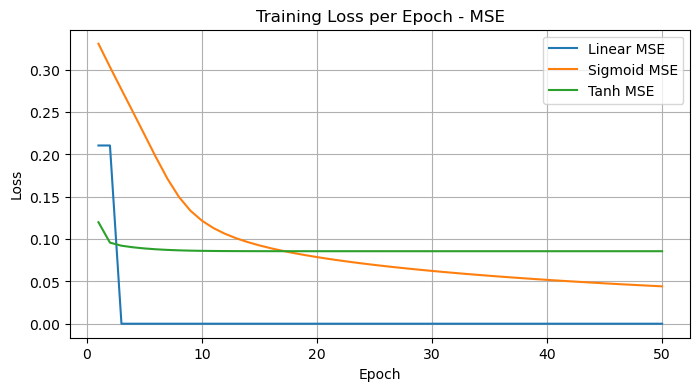

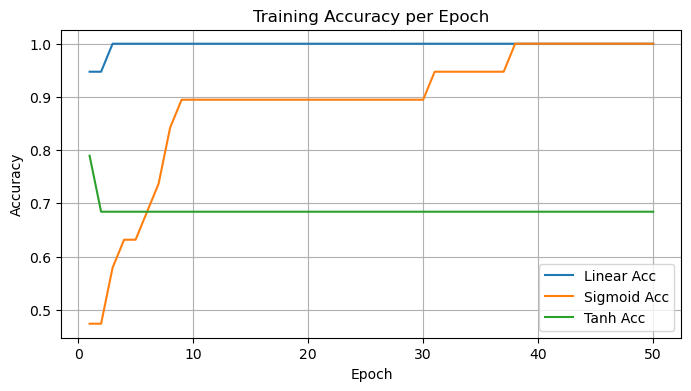

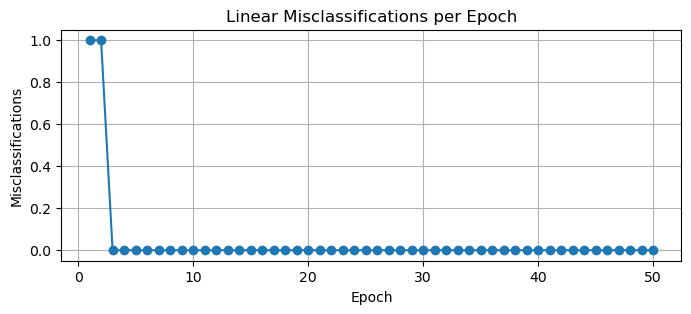

In [5]:
epochs = np.arange(1, num_epochs+1)

# Loss
plt.figure(figsize=(8,4))
plt.plot(epochs, lin_loss, label='Linear MSE')
plt.plot(epochs, sig_loss, label='Sigmoid MSE')
plt.plot(epochs, tan_loss, label='Tanh MSE')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss per Epoch - MSE')
plt.legend(); plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(epochs, lin_acc, label='Linear Acc')
plt.plot(epochs, sig_acc, label='Sigmoid Acc')
plt.plot(epochs, tan_acc, label='Tanh Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training Accuracy per Epoch')
plt.legend(); plt.grid(True)
plt.show()

# Misclassifications (linear)
plt.figure(figsize=(8,3))
plt.plot(epochs, lin_mis, marker='o')
plt.xlabel('Epoch'); plt.ylabel('Misclassifications')
plt.title('Linear Misclassifications per Epoch'); plt.grid(True)
plt.show()

### Learning rate comparison between the Perceptrons

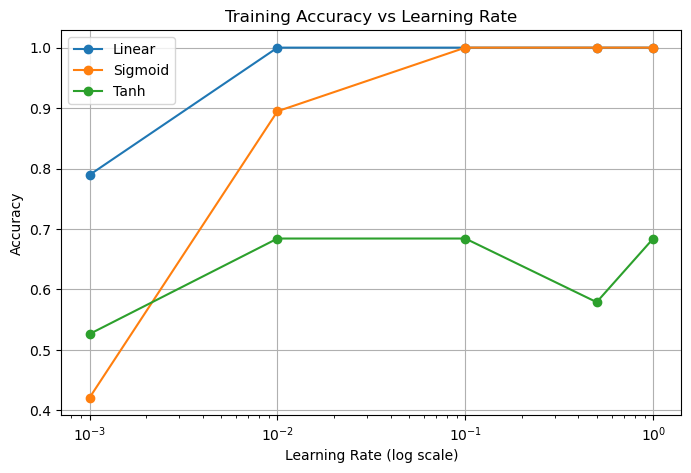

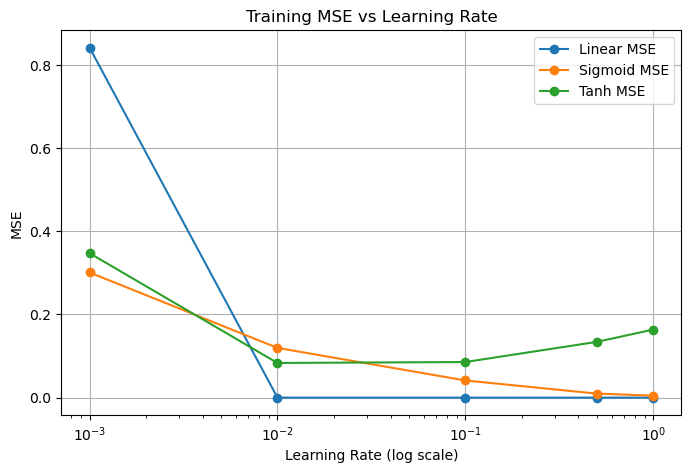

In [6]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
num_epochs = 50

results = {
    'lr': learning_rates,
    'linear_acc': [],
    'linear_mse': [],
    'sigmoid_acc': [],
    'sigmoid_mse': [],
    'tanh_acc': [],
    'tanh_mse': []
}

for lr in learning_rates:
    # Linear
    lp = LinearPerceptron(num_inputs=3, learning_rate=lr)
    lp.fit(X_train, y_train_pm, num_epochs=num_epochs)
    acc_lin = lp.evaluate(X_train, y_train_pm)
    mse_lin = lp.compute_MSE(X_train, y_train_pm)
    results['linear_acc'].append(acc_lin)
    results['linear_mse'].append(mse_lin)
    
    # Sigmoid
    nlp_sig = NonLinearPerceptron(num_inputs=3, learning_rate=lr, activation='sigmoid')
    nlp_sig.fit(X_train, y_train01, num_epochs=num_epochs)
    acc_sig = nlp_sig.evaluate(X_train, y_train01)
    probs_sig = np.array([nlp_sig.predict_proba(xi) for xi in X_train])
    mse_sig = nlp_sig.compute_MSE(probs_sig, y_train01)
    results['sigmoid_acc'].append(acc_sig)
    results['sigmoid_mse'].append(mse_sig)
    
    # Tanh
    nlp_tan = NonLinearPerceptron(num_inputs=3, learning_rate=lr, activation='tanh')
    nlp_tan.fit(X_train, y_train01, num_epochs=num_epochs)
    acc_tan = nlp_tan.evaluate(X_train, y_train01)
    probs_tan = np.array([nlp_tan.predict_proba(xi) for xi in X_train])
    mse_tan = nlp_tan.compute_MSE(probs_tan, y_train01)
    results['tanh_acc'].append(acc_tan)
    results['tanh_mse'].append(mse_tan)


df_lr = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.semilogx(df_lr['lr'], df_lr['linear_acc'], marker='o', label='Linear')
plt.semilogx(df_lr['lr'], df_lr['sigmoid_acc'], marker='o', label='Sigmoid')
plt.semilogx(df_lr['lr'], df_lr['tanh_acc'], marker='o', label='Tanh')
plt.title('Training Accuracy vs Learning Rate')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.semilogx(df_lr['lr'], df_lr['linear_mse'], marker='o', label='Linear MSE')
plt.semilogx(df_lr['lr'], df_lr['sigmoid_mse'], marker='o', label='Sigmoid MSE')
plt.semilogx(df_lr['lr'], df_lr['tanh_mse'], marker='o', label='Tanh MSE')
plt.title('Training MSE vs Learning Rate')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()